In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

disease_status  pathology  region             
DKD             abnormal   glomerulus_abnormal    65
normal          healthy    glomerulus_healthy     54
DKD             nan        tubule_PanCK           24
                           tubule_neg             24
                healthy    glomerulus_healthy     18
normal          nan        tubule_PanCK           17
                           tubule_neg             17
                abnormal   glomerulus_abnormal    12
dtype: int64


/nfs/team283/vk7/software/miniconda3farm5/envs/spacejam/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


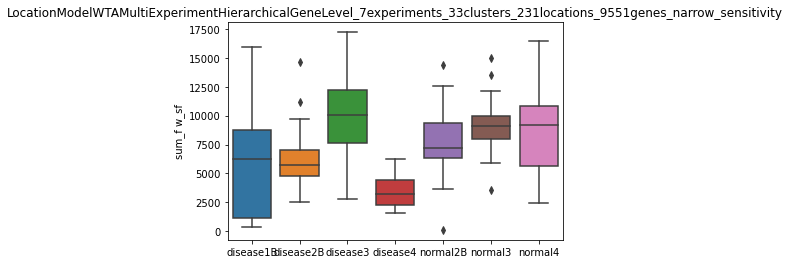

/nfs/team283/vk7/software/miniconda3farm5/envs/spacejam/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


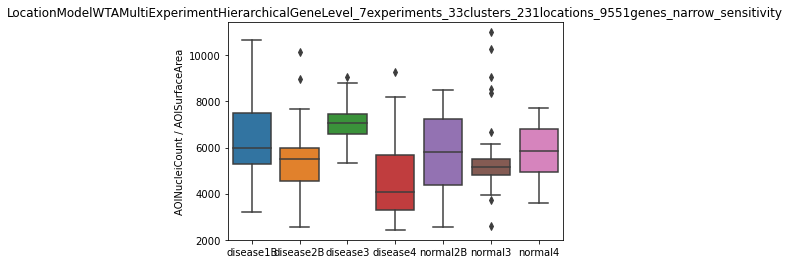

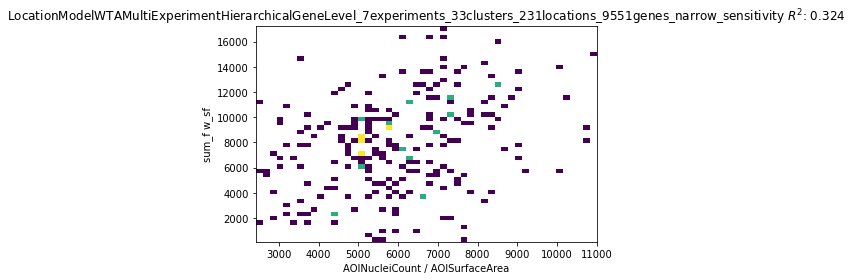

In [2]:
data_dir = '/lustre/scratch117/cellgen/team283/Kidney-Nanostring/results/'
analysis_names = [
    'LocationModelWTAMultiExperimentHierarchicalGeneLevel_7experiments_33clusters_231locations_9551genes_narrow_sensitivity'
]

for analysis_name in analysis_names:
    adata_wta = sc.read_h5ad(f'{data_dir}{analysis_name}/sp.h5ad')

    # add coordinates
    adata_wta.obsm['spatial'] = adata_wta.obs[['ROICoordinateX', 'ROICoordinateY']].values

    sel_clust = adata_wta.uns['mod']['fact_names']
    sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]
    sel_clust_new = ['q05_cell_density_per_mm2_' + str(i) for i in sel_clust]

    adata_wta.obs[sel_clust_new] = (adata_wta.obs[sel_clust_col].T / (adata_wta.obs['AOISurfaceArea'] / (10**6))).T

    adata_wta.obs['region_original'] = adata_wta.obs['region'].copy()

    adata_wta.obs['pathology_aux'] = adata_wta.obs['pathology'].astype(str).copy()
    adata_wta.obs.loc[adata_wta.obs['region_original'] != 'glomerulus', 'pathology_aux'] = ''

    adata_wta.obs['SegmentLabel_aux'] = adata_wta.obs['SegmentLabel'].astype(str).copy()
    adata_wta.obs.loc[adata_wta.obs['region_original'] == 'glomerulus', 'SegmentLabel_aux'] = ''

    adata_wta.obs['region'] = adata_wta.obs['region'].astype(str) \
    + '_'+ adata_wta.obs['SegmentLabel_aux'].astype(str) + adata_wta.obs['pathology_aux'].astype(str)
    print(adata_wta.obs[['disease_status', 'pathology', 'region']].value_counts())

    sns.boxplot(adata_wta.obs['SlideName'].values, adata_wta.obs[sel_clust_new].sum(1).values);
    plt.title(analysis_name);
    plt.ylabel('sum_f w_sf');
    plt.show()
    
    sns.boxplot(adata_wta.obs['SlideName'].values, 
                adata_wta.obs['AOINucleiCount'].values / (adata_wta.obs['AOISurfaceArea'].values / (10**6)));
    plt.title(analysis_name);
    plt.ylabel('AOINucleiCount / AOISurfaceArea');
    plt.show()
    
    x = (adata_wta.obs['AOINucleiCount'].values / (adata_wta.obs['AOISurfaceArea'].values / (10**6))).flatten()
    y = adata_wta.obs[sel_clust_new].sum(1).values.flatten()
    plt.hist2d(x, y,
               bins=50, norm=matplotlib.colors.LogNorm());
    plt.xlabel('AOINucleiCount / AOISurfaceArea');
    plt.ylabel('sum_f w_sf');
    plt.title(f'{analysis_name} ' + r'$R^2$: ' \
          + str(np.round(np.corrcoef(x, y), 3)[0,1]));
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    id_vars = ['SegmentDisplayName', 'SlideName', 'disease_status', 'region']
    obs_covar = adata_wta.obs[sel_clust_new + id_vars]

    obs_covar = pd.melt(obs_covar, id_vars=id_vars, 
                        value_vars=None, 
                        var_name='cell_type', value_name='cell_density')

    obs_covar.to_csv(f'{data_dir}{analysis_name}/obs_melted.csv')
    obs_covar